# Prereading

Familiarize yourself with the following code and the algorithm it implements

## Adaptive Squeezed Rejection Sampling

The `AdaptiveSqueezedRejectionSampling` class below
executes the ***(derivative-based) adaptive (squeezed) rejection sampling*** algorithm:

> 0. Given two continuous piecewise linear functions, defined by upper $up_k(x)$ and lower $lo_k(x)$, which are respectively
>    - bound the convex log likelihood of a target distribution $f(x)$ from above and below
>    - constructed by the intersection of the tangents (above) and secants (below) $\log f(x)$ made from $K$ points $\{(x_k,f(x_k)):k=1,\cdots, K\}$
> 
>
> 1. Sample $x^*$ from the exponentiated upper hull (proposal distribribution) which is an unnormalized continuous density of piecewise truncated scaled exponential distributions connected end to end by
>    1. randomly choosing one of the piecewise truncated scaled exponential distributions based on their relative areas
>    2. sampling from the chosen piecewise truncated scaled exponential distribution
> 2. Use $x^*$ sampled from the $k^{th}$ chosen piecewise truncated scaled exponential distribution an adaptive rejection sampling proposal as follows
>    1. Sample a unform random variable $u$ and accept the proposal $x^*$ immediately if $u < e^{lo_k(x^*)-up_k(x^*)}=e^{lo_k(x^*)}/e^{up_k(x^*)}$ 
>    2. Otherwise accept $x^*$ if $u < f(x^*)/e^{up_k(x^*)}$, which will happen with probability $\frac{f(x^*)-e^{lo_k(x^*)}}{e^{up_k(x^*)}}$
>       1. and add $x^*$ to the (now) $K+1$ points defining $up_k(x)$ and $lo_k(x)$
> 3. If $x^*$ was not accepted discard $x^*$ 
>
>
> 4. Return to step 1 as desired

*This problem is inspired by sections 6.2.3.2 and 6.2.3.1 **Adaptive Rejection Sampling** and **Squeezed Rejection Sampling** on pages 158-163 in Chapter 6.2.3 **Exact Simulation: Rejection Sampling** of the [Givens and Hoeting **Computational Statistics**](https://librarysearch.library.utoronto.ca/permalink/01UTORONTO_INST/14bjeso/alma991106781097906196) textbook which introduce the **Adaptive Rejection Sampling** methodology that formed the basis of the first-generation universal probabilistic programming tool **WinBugs**, which (for many models) allowed users to automatically draw samples from the posterior of a Bayesian analysis based just on an initial probability model (likelihood and a prior) specification and not requiring the user to perform any of their own derivations of the posterior distribution.* 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time 

In [4]:
class AdaptiveSqueezedRejectionSampling(object):

    def __init__(self, target, logpdf, ddxlogf, a, b, n, xk, samples):
        
        self.target, self.logpdf, self.ddxlogf = target, logpdf, ddxlogf
        self.a, self.b = a, b
        
        self.xk,self.zk = np.array([]),np.array([])
        self.Adapt(list(xk))
        
        self.n_ = len(xk)
        self.samples = np.zeros(n)        
        self.n = len(samples)
        self.samples[:self.n] = samples
        self.buffer = np.array([])
        
        self.rejected = 0
        self.run()

    def Adapt(self, xk):
        self.xk = np.sort(xk)
        # make zk to track the tangent intersections; which, therefore, solves
        # self.logpdf(self.xk[:-1]) + (zk - self.xk[:-1]) * self.ddxlogf(self.xk[:-1]) ==
        # self.logpdf(self.xk[1:]) + (zk - self.xk[1:]) * self.ddxlogf(self.xk[1:])
        first_term = self.logpdf(self.xk[1:]) - self.logpdf(self.xk[:-1])  # subtract from left side
        third_term = self.xk[:-1]*self.ddxlogf(self.xk[:-1]) - self.xk[1:]*self.ddxlogf(self.xk[1:])
        z_multiple = self.ddxlogf(self.xk[:-1]) - self.ddxlogf(self.xk[1:])
        self.zk = (first_term+third_term)/z_multiple
        
    def UpperPiecewiseTangent(self, x):
        @np.vectorize
        def _UpperPiecewiseTangent(x):
            i = np.sum(x > self.zk)  # which piecewise tangent function?
            return self.logpdf(self.xk[i]) + (x-self.xk[i])*self.ddxlogf(self.xk[i])
        return _UpperPiecewiseTangent(x)
    
    def LowerPiecewiseSecant(self, x):
        @np.vectorize
        def _LowerPiecewiseSecant(x):  
            if x<self.xk[0] or x>self.xk[-1]:  # left or right of secant pieces?
                return -np.inf  # np.exp(-np.inf) is 0 for x in [-inf,x1] or [xK,inf]
                # means that exp(LowerPiecewiseSecant) == 0 for [-inf,x1] and [xK,inf]
            else:
                i = np.sum(x > self.xk)-1  # which piecewise secant function?
                left_y,right_y = self.logpdf(self.xk[i]),self.logpdf(self.xk[i+1])
                left_x,right_x = self.xk[i],self.xk[i+1]
                return left_y + (x-left_x) * (right_y-left_y)/(right_x-left_x)
                # equals left_y*p + right_y*(1-p) for p = (right_x-x)/(right_x-left_x) 
        return _LowerPiecewiseSecant(x)

    def ExponentiatedUpperPiecewiseTangentIntervalAreas(self):
        p = 0*self.xk
        for i in range(len(self.xk)):
            if i == 0:  # leftward facing *non trucated* scaled exponential distribution
                a, b = self.a, self.zk[i]
                if np.isinf(self.a):
                    a, b = -np.inf, self.zk[i]
            elif i == (len(self.xk)-1):  # rightward facing *non trucated* scaled exponential distribution
                a, b = self.zk[i-1], self.b
                if np.isinf(self.b):
                    a, b = self.zk[i-1], self.b                
            else:
                a, b = self.zk[i-1], self.zk[i]  # [left|right]ward facing *tail truncated* scaled exponential 
                # where the facing direction of the distribution depends on tangent slope
            
            # the integral over [a,b] exp( log f(xk) + (log f(xk))' (x - xk) ) dx 
            p[i] = self.target(self.xk[i])*np.exp(-self.xk[i]*self.ddxlogf(self.xk[i]))
            p[i] = p[i]*( np.exp(self.ddxlogf(self.xk[i])*b) -
                          np.exp(self.ddxlogf(self.xk[i])*a) )/self.ddxlogf(self.xk[i])
        return p

    def SampleUpperPiecewiseTangentIntervals(self, n):
        p = self.ExponentiatedUpperPiecewiseTangentIntervalAreas()
        return np.argmax(stats.multinomial(n=1, p=p/p.sum()).rvs(size=n), axis=1)

    def SampleFromExponentiatedUpperPiecewiseTangentIntervals(self, i):
        
        @np.vectorize
        def _SampleFromExponentiatedUpperPiecewiseTangentInterval(i):
            𝜆 = self.ddxlogf(self.xk[i])
            if (i > 0) and (i < len(self.zk)):
                a,b = self.zk[i-1],self.zk[i]
            if i == 0:
                # stats.expon?
                # A common parameterization for `expon` is in terms of the rate parameter
                # ``lambda``, such that ``pdf = lambda * exp(-lambda * x)``. This
                # parameterization corresponds to using ``scale = 1 / lambda``.
                if np.isinf(self.a):
                    return self.zk[0] - stats.expon(scale=1/𝜆).rvs()
                return self.zk[0] - stats.truncexpon(scale=1/𝜆, b=𝜆*(self.zk[0]-self.a)).rvs()
            elif self.ddxlogf(self.xk[i]) > 0:
                # stats.truncexpon?
                # The probability density function for `truncexpon` is:
                # `f(x, b) = \frac{\exp(-x)}{1 - \exp(-b)}` for `0 <= x <= b`.
                # The probability density above is defined in the "standardized" form. 
                # To scale the distribution use the ``scale`` parameter.
                # Specifically, ``truncexpon.pdf(x, b, loc, scale)`` is identically
                # equivalent to ``truncexpon.pdf(y, b) / scale`` with ``x = y * scale``.
                return self.zk[i] - stats.truncexpon(scale=1/𝜆, b=𝜆*(b-a)).rvs()
                # `𝜆*(b-a)` is (b-a)/scale so when multiplied by scale we get truncation at (b-a)
                # "y with scale = 1 is sampled and then multiplicatively stretched by scale"
            elif i == len(self.zk):                
                if np.isinf(self.b):
                    return self.zk[-1] + stats.expon(scale=1/-𝜆).rvs()
                return self.zk[-1] + stats.truncexpon(scale=1/-𝜆, b=-𝜆*(self.b-self.zk[-1])).rvs()
            else:
                return self.zk[i-1] + stats.truncexpon(scale=1/-𝜆, b=-𝜆*(b-a)).rvs()
            
        return _SampleFromExponentiatedUpperPiecewiseTangentInterval(i)

    def SampleFromProposalDistribution(self, n):
        return self.SampleFromExponentiatedUpperPiecewiseTangentIntervals(self.SampleUpperPiecewiseTangentIntervals(n))

    def AdaptiveSqueezedRejectionSample(self):
        x = self.SampleFromProposalDistribution(1)[0]
        u = stats.uniform.rvs(size=1)
        #print(u, np.exp(self.LowerPiecewiseSecant(x)), self.target(x), np.exp(self.UpperPiecewiseTangent(x)), x)
        if u <= np.exp(self.LowerPiecewiseSecant(x)-self.UpperPiecewiseTangent(x)):
            return x
        elif u <= self.target(x)/np.exp(self.UpperPiecewiseTangent(x)):
            self.Adapt(self.xk.tolist()+[x])
            return x
        
        else:
            self.rejected += 1
            return self.AdaptiveSqueezedRejectionSample()
            
    def AdaptiveSqueezedRejectionSamples(self, n):
        
        if self.buffer.shape[0] > n:
            n = self.buffer.shape[0]
        x_ = np.zeros(n)
        x_[:self.buffer.shape[0]] = self.buffer
        if self.buffer.shape[0]<n:
            x_[self.buffer.shape[0]:] = self.SampleFromProposalDistribution(n-self.buffer.shape[0])
        u = stats.uniform.rvs(size=n)
        
        keep = u <= np.exp(self.LowerPiecewiseSecant(x_)-self.UpperPiecewiseTangent(x_))
        above_secant = (~keep).cumsum()
        n_ = (above_secant.cumsum()<1).sum()  # keep up to the first one failing
        self.buffer = x_[(n_+1):]
        x = x_[:n_].tolist()        
        if n_<n:
            x_ = x_[n_]
            if u[n_] <= self.target(x_)/np.exp(self.UpperPiecewiseTangent(x_)):
                self.Adapt(self.xk.tolist()+[x_])
                x += [x_]
            else:
                self.rejected += 1
        return x
    
    def run(self):
        
        #print(self.n_, self.buffer.shape[0])
        x = self.AdaptiveSqueezedRejectionSamples(self.n_)
        n_ = min(len(x), self.samples.shape[0]-self.n)
        #print(self.n_, n_, self.rejected, len(self.xk))        
        self.samples[self.n:(self.n+n_)] = x[:n_]
        self.n += n_
        
        if self.n < self.samples.shape[0]:

            self.n_ = n_+len(self.xk)
            self.run()

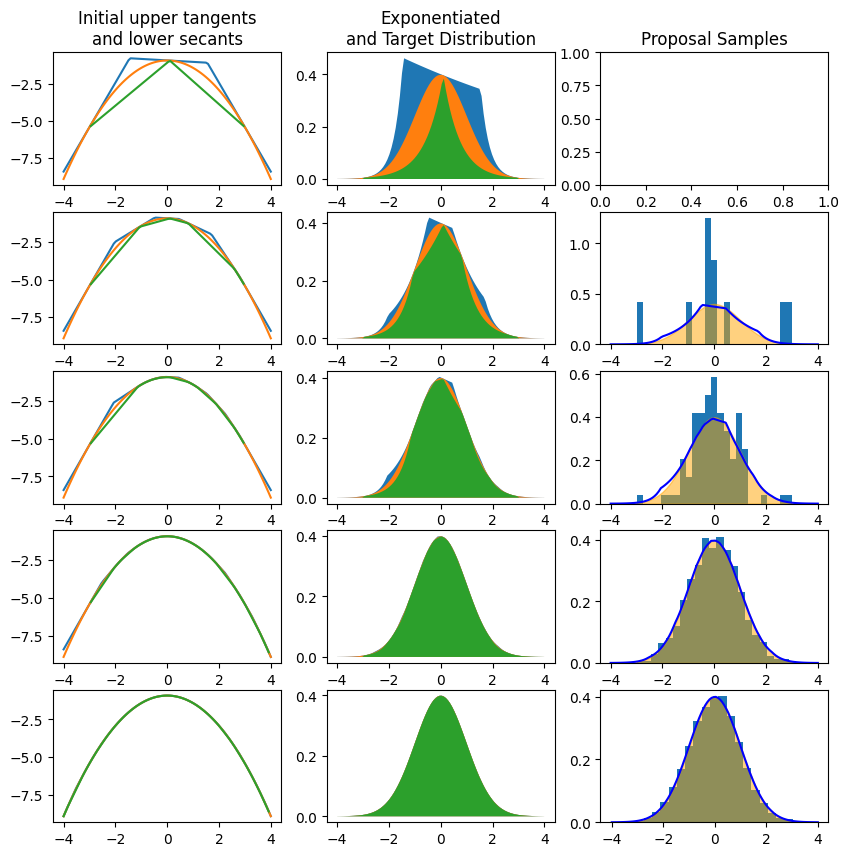

In [5]:
mu,sigma = 0,1
target = lambda x: stats.norm(loc=mu,scale=sigma).pdf(x)
logpdf = lambda x: stats.norm(loc=mu,scale=sigma).logpdf(x)
scoref = lambda x: -(x-0)/sigma**2 
xk = np.array([-3., .1, 3.])

np.random.seed(4)
ASRS = AdaptiveSqueezedRejectionSampling(target, logpdf, scoref, -5, 5, 3, xk, xk)

fig,ax = plt.subplots(5, 3, figsize=(10,10))
support = np.linspace(-4,4,100)

ax[0,0].plot(support, ASRS.UpperPiecewiseTangent(support))
ax[0,0].plot(support, ASRS.logpdf(support))
ax[0,0].plot(support, ASRS.LowerPiecewiseSecant(support))
ax[0,0].set_title("Initial upper tangents\nand lower secants")

ax[0,1].fill_between(support, 0, np.exp(ASRS.UpperPiecewiseTangent(support)))
ax[0,1].fill_between(support, 0, ASRS.target(support))
ax[0,1].fill_between(support, 0, np.exp(ASRS.LowerPiecewiseSecant(support)))
ax[0,1].set_title("Exponentiated\nand Target Distribution")

ax[0,2].set_title("Proposal Samples")

for i in range(1,5):
    ASRS = AdaptiveSqueezedRejectionSampling(target, logpdf, scoref, -5, 5, 10**i, ASRS.xk, ASRS.samples)

    ax[i,0].plot(support, ASRS.UpperPiecewiseTangent(support))
    ax[i,0].plot(support, ASRS.logpdf(support))
    ax[i,0].plot(support, ASRS.LowerPiecewiseSecant(support))

    ax[i,1].fill_between(support, 0, np.exp(ASRS.UpperPiecewiseTangent(support)))
    ax[i,1].fill_between(support, 0, ASRS.target(support))
    ax[i,1].fill_between(support, 0, np.exp(ASRS.LowerPiecewiseSecant(support)))

    ax[i,2].hist(ASRS.samples, bins=25, density=True)
    c = ASRS.ExponentiatedUpperPiecewiseTangentIntervalAreas().sum()
    ax[i,2].plot(support, np.exp(ASRS.UpperPiecewiseTangent(support))/c, color='blue')
    ax[i,2].fill_between(support, 0, ASRS.target(support), color='orange', alpha=0.5)


n = 10000 2.2396059036254883
n = 10000 13.8442702293396
n = 10000 15.655341148376465


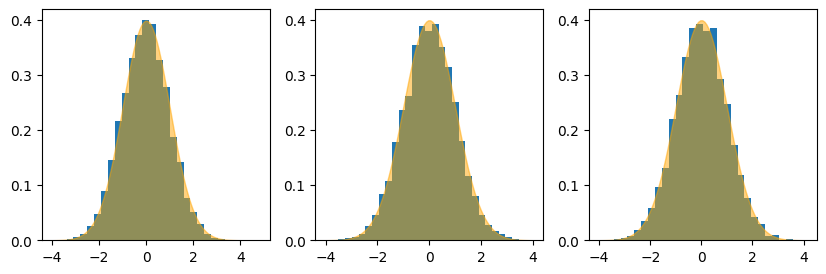

In [6]:
fig,ax = plt.subplots(1, 3, figsize=(10,3))

n = ASRS.n

toc = time.time()
x = ASRS.SampleFromProposalDistribution(n)
ax[0].hist(x, bins=30, density=True)
ax[0].fill_between(support, 0, ASRS.target(support), color='orange', alpha=0.5)
tic = time.time()
print("n =", len(x), tic-toc)

toc = time.time()
ASRS = AdaptiveSqueezedRejectionSampling(target, logpdf, scoref, -5,5, 2*n, ASRS.xk, ASRS.samples)
x = ASRS.samples[n:]
ax[1].hist(x, bins=30, density=True)
ax[1].fill_between(support, 0, ASRS.target(support), color='orange', alpha=0.5)
tic = time.time()
print("n =", len(x), tic-toc)

toc = time.time()
ASRS = AdaptiveSqueezedRejectionSampling(target, logpdf, scoref, -5,5, n, xk, xk)
x = ASRS.samples
ax[2].hist(x, bins=30, density=True)
ax[2].fill_between(support, 0, ASRS.target(support), color='orange', alpha=0.5)
tic = time.time()
print("n =", len(x), tic-toc)


# Lecture

First hour of class

### Sampling from the proposal distribution of the Adaptive Squeezed Rejection Sampling 

#### `ExponentiatedUpperPiecewiseTangentIntervalAreas`

$$
\Large
\begin{align*}
\lambda & = {} \frac{d}{dx} \log f(x) \\
\int_{a}^{b} \exp\left( \log f(x_k) + \lambda (x-x_k) \right) dx & = {} 
\int_{0}^{b-a} \exp\left( \log f(x_k) + \lambda (x+a-x_k) \right) dx\\
& = {} \frac{f(x_k) \exp(-\lambda x_k) \exp(\lambda a)}{\lambda} {{\underset{\exp\left(\lambda x \right)|_0^{b-a} }{\int_{0}^{b-a} \lambda \exp\left( \lambda x \right) dx}}}\\
& = {} \frac{f(x_k) \exp(\lambda x_k) }{\lambda}  \left[\exp( \lambda b) - \exp\left( \lambda a \right) \right]
\end{align*}
$$

#### `SampleFromExponentiatedUpperPiecewiseTangentIntervals`
## If $\lambda < 0$

$\Large \displaystyle -c\int_{0}^{b-a} -\lambda \exp\left( \lambda x \right) dx$ integrates a scaled exponential distribution $\Large \texttt{stats.expon(scale=-1/𝜆, b=𝑏−𝑎)}$

## If $\lambda > 0$

$\Large \displaystyle c\int^0_{-(b-a)} \lambda \exp\left( -\lambda ((b-a)-x) \right) dx = c\int_0^{b-a} \lambda \exp\left( -\lambda y \right) dx$ integrates a scaled exponential distribution $\Large \texttt{stats.expon(scale=1/𝜆, b=𝑏−𝑎)}$



# Class Coding Challenge

This is
- in person in approximately the final two hours of class
- open notes and open internet **but you may not collaborate with classmates**

This will 

- utilize the coding skills practiced on the homework
- ask questions regarding the prelecture homework
- ask questions regarding the prelecture reading
- ask questions regarding the lecture itself